# Principal Component Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def mrow (n):
    return n.reshape(1, n.size)

def mcol (n):
    return n.reshape(n.size, 1)


In [3]:
def load(fname):
    DList = []
    labelsList = []
    hLabels = {
        'Iris-setosa': 0,
        'Iris-versicolor': 1,
        'Iris-virginica': 2
        }

    with open(fname) as f:
        for line in f:
            try:
                attrs = line.split(',')[0:-1]
                attrs = mcol(np.array([float(i) for i in attrs]))
                name = line.split(',')[-1].strip()
                label = hLabels[name]
                DList.append(attrs)
                labelsList.append(label)
            except:
                pass

    return np.hstack(DList), np.array(labelsList, dtype=np.int32)


In [4]:
D, L = load("iris.csv")
mu = D.mean(axis=1)
#We center the data
DC = D - mcol(mu)
C = np.dot(DC, DC.T) / D.shape[1]
print("mu : ", mu)
print("covariance matrix : ")
print(C)

mu :  [5.84333333 3.05733333 3.758      1.19933333]
covariance matrix : 
[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]


In [5]:
#if it was not squared we should have used --> numpy.linalg.eig
#eig does not sort the eigenvalues and eigenvectors, while eigh returns the eigenvalues, sorted from smallest to largest, and the corresponding eigenvector
#eigh is for symmetric matrices
s, U = np.linalg.eigh(C)
print("Eigenvalues : ", s)
print("Eigenvectors : ")
print(U)

Eigenvalues :  [0.02367619 0.0776881  0.24105294 4.20005343]
Eigenvectors : 
[[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


[[-0.36138659  0.65658877]
 [ 0.08452251  0.73016143]
 [-0.85667061 -0.17337266]
 [-0.3582892  -0.07548102]]


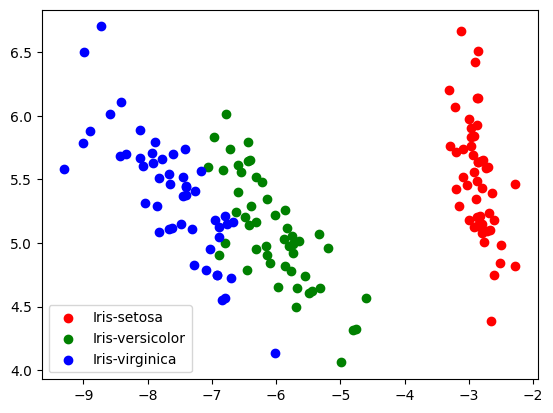

In [6]:

# m is equal 2 because we want to reduce the dimensionality of the data to a 2D space
m = 2
#we also reverse the order of the columns of U so that the leading eigenvectors are in the first m columns
P = U[:, ::-1][:, 0:m]
print(P)
#Since the covariance matrix is semi-definite positive, we can also get the sorted eigenvectors from the Singular Value Decomposition (SVD)
#U, s, Vh = np.linalg.svd(C)
#P = U[:, 0:m]
#print(P)

#Finally, we can apply the projection to a single point x or to a matrix of samples D as --> y = numpy.dot(P.T, x) or Y = numpy.dot(P.T, D)
DP = np.dot(P.T, D)

plt.scatter(DP[0, L == 0], DP[1, L == 0], c='r', label='Iris-setosa')
plt.scatter(DP[0, L == 1], DP[1, L == 1], c='g', label='Iris-versicolor')
plt.scatter(DP[0, L == 2], DP[1, L == 2], c='b', label='Iris-virginica')
plt.legend()
plt.show()

# Linear Discriminant Analysis

#### To compute the LDA transformation matrix W we need to compute the between and within class covariance matrices


### The covariance of each class SW,c can be computed as we did for PCA:
##### • Compute the mean for the class samples
##### • Remove the mean from the class data
##### • Compute SW,c as in (1) using the centered data matrix of the class samples, and nc as the number of samples

In [ ]:
#centered data matrix
DC


# PCA and LDA for classification